# BLU06 - Learning Notebook - Part 3 of 3 - Advanced topics on ML for Time Series Forecasting

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm

plt.rcParams['figure.figsize'] = (12, 4.2)

import utils # we added the functions from the last notebooks to utils

In this notebook, we'll see how to use exogenous features in time series regression, explore special cross-validation strategies for time series, and show one way of measuring uncertainty in the forecast.

## 1. Exogenous Features

We already learned how to use exogenous features for the ARIMA models, but what about regression models? It's actually pretty straightforward! Let's train a regression model for the solar power production that we used in BLU05.

In [2]:
df_solar = utils.load_solar_data()
df_solar.head()

,Power
Datetime,
2016-01-01 07:00:00+00:00,0.000000
2016-01-01 08:00:00+00:00,641.772625
2016-01-01 09:00:00+00:00,4670.041125
2016-01-01 10:00:00+00:00,6864.839375
2016-01-01 11:00:00+00:00,6030.192250


We will take a longer train set and a shorter test set than in the previous BLU, otherwise we won't have enough train data for the models with larger `num_periods_ahead`.

In [3]:
train_solar = df_solar.loc[:'2016-01-21']
test_solar = df_solar.loc['2016-01-22':'2016-02-01']

This will be our baseline, a gradient boosting regressor with 23 lags to capture the seasonality.

In [4]:
forecast_solar = utils.multistep_forecast(train_solar.Power,
                                    model=GradientBoostingRegressor(random_state=10, n_estimators=20),
                                    num_lags=23,
                                    num_diffs=0,
                                    weekday=False,
                                    month=False,
                                    holidays=False,
                                    num_periods_ahead=test_solar.shape[0]) 
    
test_solar_mae = mean_absolute_error(test_solar.Power,forecast_solar)
print(test_solar_mae)

1316.928149912757


Let's plot this baseline.

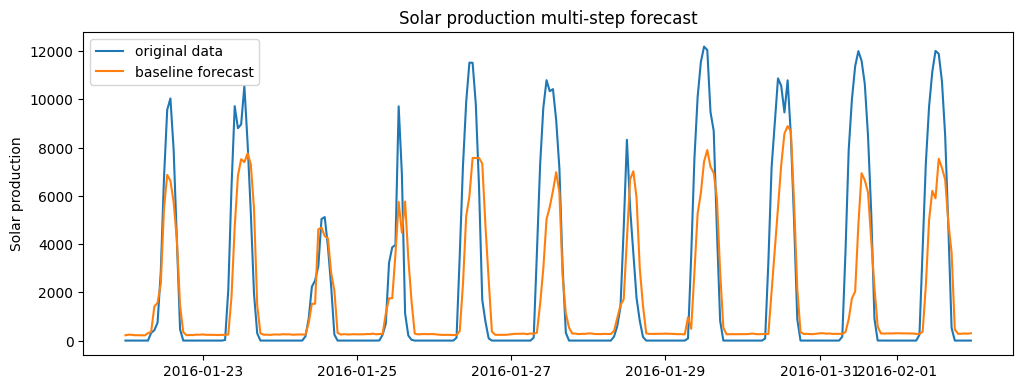

In [5]:
plt.plot(test_solar, label="original data")
plt.ylabel('Solar production')
plt.plot(pd.Series(forecast_solar, index=test_solar.index), label="baseline forecast")
plt.title('Solar production multi-step forecast')
plt.legend();

It's a pretty good baseline, but there is room for improvement in the height of the peaks

### 1.1 Adding exogenous features

Now let's load the exogenous variable which corresponds to the radiation forecast as you might recall.

In [6]:
df_exog = utils.load_solar_radiation_data()
df_exog.head()

,radiation
Datetime,
2016-01-01 00:00:00+00:00,107.783186
2016-01-01 01:00:00+00:00,94.415697
2016-01-01 02:00:00+00:00,88.347165
2016-01-01 03:00:00+00:00,90.964571
2016-01-01 04:00:00+00:00,85.484427


Remember that our exogenous variable corresponds to a **forecast** for the date seen in the index. This means that when we're performing the solar production forecast for tomorrow we want to have access to the solar irradiation forecast for tomorrow. So we have to shift the exogenous variable by the same amount as the target, which is `num_periods_ahead` in our code. Then we can additionally use lags or diffs of this shifted exogenous variable if we like.

The function below adds the exogenous variable to the feature dataframe. The selection of timepoints for the exogenous variable is achieved by shifting the values and then selecting the dates with the index of the feature dataframe, the `df` parameter in the function.

Notice the extra feature `leads`. This is the exogenous variable shifted to the future. The rationale is that as the exogenous variable is correlated with itself, with its own future values - leads, and it is also correlated with the target, the leads should help to predict the future target.

In [7]:
def build_exog_features(df, exog, num_periods_ahead, num_exog_lags=0, num_exog_diffs=0, num_exog_leads=0):
    """ 
    Adds the exogenous feature and the specified number of lags and diffs.
    """
    df_=df.copy()
    if exog is not None:
        df_['exog']=exog.shift(-num_periods_ahead).loc[df_.index]
        for i in np.arange(1, num_exog_lags+1):
            df_['exog_lag_'+str(i)] = exog.shift(i)
        for i in np.arange(1, num_exog_diffs+1):
            df_['exog_diff_'+str(i)] = exog.diff(-i)
        for i in np.arange(1, num_exog_leads+1):
            df_['exog_lead_'+str(i)] = exog.shift(-i)        
    return df_

To show how it works, we will add the exogenous variable shifted by 2 periods ahead to a copy of the `train_solar` data.

In [8]:
df_ = train_solar.copy()
df_ = build_exog_features(df_,df_exog.radiation,num_periods_ahead=2)

Look how the last exog values in this dataframe, 19:00-23:00 on Jan 21, correspond to the values of the exogenous variables from 21:00 on Jan 21 to 1:00 on Jan 22.

In [9]:
df_.tail()

,Power,exog
Datetime,,
2016-01-21 19:00:00+00:00,0.0,95.847282
2016-01-21 20:00:00+00:00,0.0,93.522757
2016-01-21 21:00:00+00:00,0.0,93.576946
2016-01-21 22:00:00+00:00,0.0,93.115199
2016-01-21 23:00:00+00:00,0.0,89.836232


In [10]:
df_exog.loc['2016-01-21 21:00:00':'2016-01-22 03:00:00']

,radiation
Datetime,
2016-01-21 21:00:00+00:00,95.847282
2016-01-21 22:00:00+00:00,93.522757
2016-01-21 23:00:00+00:00,93.576946
2016-01-22 00:00:00+00:00,93.115199
2016-01-22 01:00:00+00:00,89.836232
2016-01-22 02:00:00+00:00,95.485072
2016-01-22 03:00:00+00:00,91.039557


Now we use the exogenous variable in the multi-step forecast. We don't use any leads or lags or diffs of the variable here, just its value (feel free to test it yourself).

In [11]:
forecast_exog = utils.multistep_forecast(train_solar.Power,
                                    model=GradientBoostingRegressor(random_state=10, n_estimators=20),
                                    num_lags=23,
                                    num_diffs=0,    
                                    weekday=False,
                                    month=False,
                                    holidays=False,
                                    num_periods_ahead=test_solar.shape[0],
                                    exog=df_exog.radiation)

test_exog_mae = mean_absolute_error(test_solar.Power,forecast_exog)
print(test_exog_mae)

472.07642696820375


Similarly to the case of ARIMA models, the exogenous data significantly improved the model performance! The peaks are now reaching the correct height. (Although we have to admit that this is a very easy dataset.)

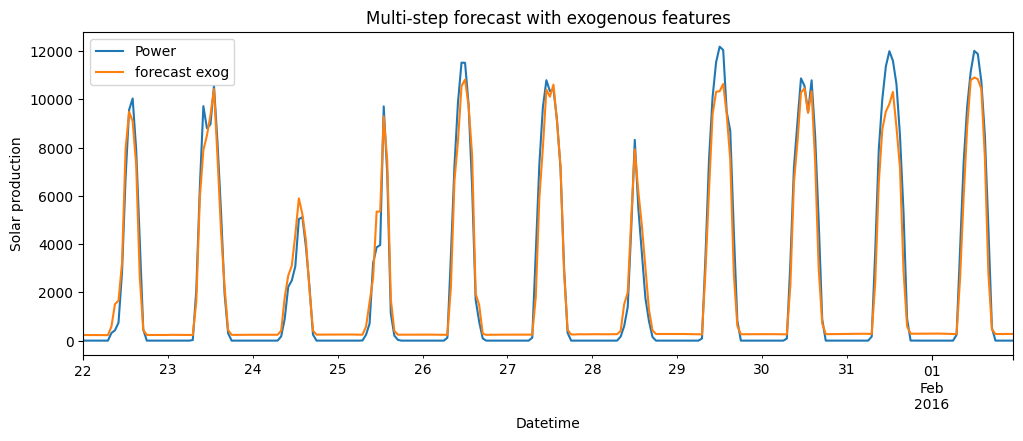

In [12]:
test_solar.plot(label="original data")
plt.ylabel('Solar production')
pd.Series(forecast_exog, index=test_solar.index).plot(label="forecast exog")
plt.title('Multi-step forecast with exogenous features')
plt.legend();

## 2. Time series cross validation

We will use the store data from the last notebook. The first steps will be to clean it and prepare the train and test sets.

In [13]:
store = utils.get_store_one_data()
store_resampled = store.resample('D').asfreq()
store_cleaned = store_resampled.fillna(0)

In [14]:
test_split_date = '2017-6'
store_train = store_cleaned.loc[store_cleaned.index < test_split_date]
store_test = store_cleaned.loc[store_cleaned.index >= test_split_date]

Remember that we obtained a better score on the test set than on the validation set in the last notebook? Well, in fact the type of validation we were doing was quite simple, using only one fold. As you learned in the bootcamp, it's better to use more folds to get a better approximation of the test error because the model might not perform the same on different parts of the data.

Sklearn model selection module offers several dataset [splitters](https://scikit-learn.org/stable/api/sklearn.model_selection.html#splitters) to generate folds for cross validation. Let's look at some of them.

### 2.1 K-fold splitter
The [Kfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) splitter divides the data into k parts and each part is used as the test set in one CV iteration. Below we plot the splits for each CV iteration, with the train set shown in green and the validation sets in orange.

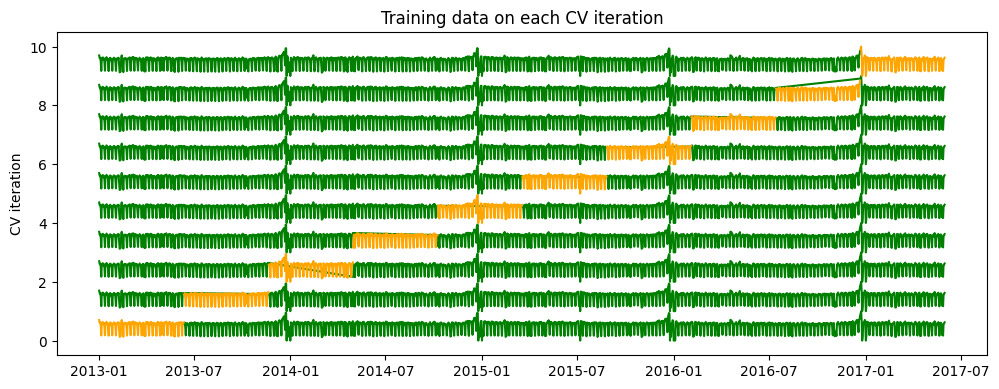

In [15]:
# Create the cross-validation object
cv = KFold(n_splits=10)

fig, ax = plt.subplots()
# tr and tt are the training and validation set indices resp.
for ii, (tr, tt) in enumerate(cv.split(store_train/store_train.max())):
    ax.plot(store_train.index[tr], ii + store_train.iloc[tr]/store_train.max(), color='green')
    ax.plot(store_train.index[tt], ii + store_train.iloc[tt]/store_train.max(), color='orange')

ax.set(title='Training data on each CV iteration', ylabel='CV iteration');

This way of splitting might be problem for time series data in case you use lagged and diffed features because there would be data leakage.

### 2.2 Time series splitter with expanding window

A better method for doing cross validation with time series is the [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit) splitter. Here the validation set comes always after the train set. By default, the train set expands with each fold as shown in the plot below. This configuration avoids leakage and allows you to inspect how well the model generalizes to different parts of the time series.

In [16]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

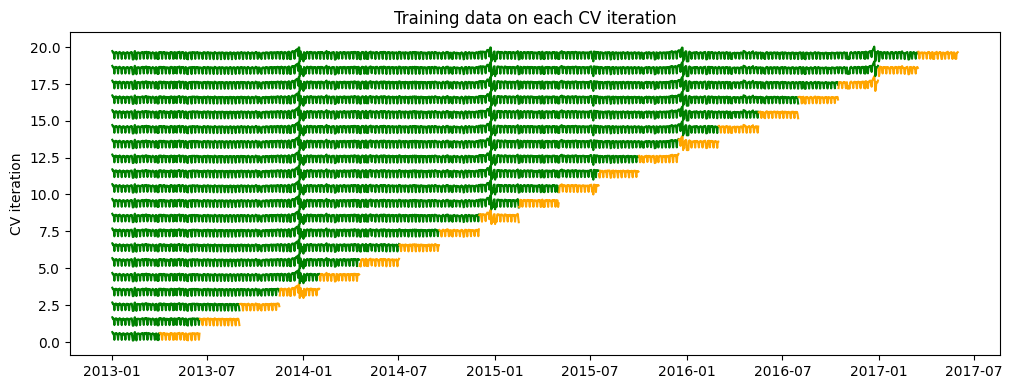

In [17]:
cv = TimeSeriesSplit(n_splits=20)

fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(store_train/store_train.max())):
    ax.plot(store_train.index[tr], ii + store_train.iloc[tr]/store_train.max(), color='green')
    ax.plot(store_train.index[tt], ii + store_train.iloc[tt]/store_train.max(), color='orange')

ax.set(title='Training data on each CV iteration', ylabel='CV iteration');

Here we perform cross validation for the multi-step forecast with the expanding window folds. We train a model on each green fold and evaluate it on the orange fold. Then we plot the MAE for each fold.

In [18]:
n_splits = 20
cv = TimeSeriesSplit(n_splits=n_splits)

idx_lst = []
mae_expanding_lst = []

for ii, (tr, tt) in tqdm(enumerate(cv.split(store_train.customers))):
    # Fit the model on training data and collect the coefficients
    train = store_train.iloc[tr].customers
    val = store_train.iloc[tt].customers
    idx_lst.append(store_train.index[tt][0])
    forecast = utils.multistep_forecast(original=train, 
                                     model=GradientBoostingRegressor(random_state=10, n_estimators=20, learning_rate=0.5),
                                     num_lags=2,
                                     num_diffs=0,
                                     weekday=True,
                                     num_periods_ahead=len(val))
    
    mae_expanding_lst.append(mean_absolute_error(val,forecast))

0it [00:00, ?it/s]

Let's plot the MAE for each validation set.

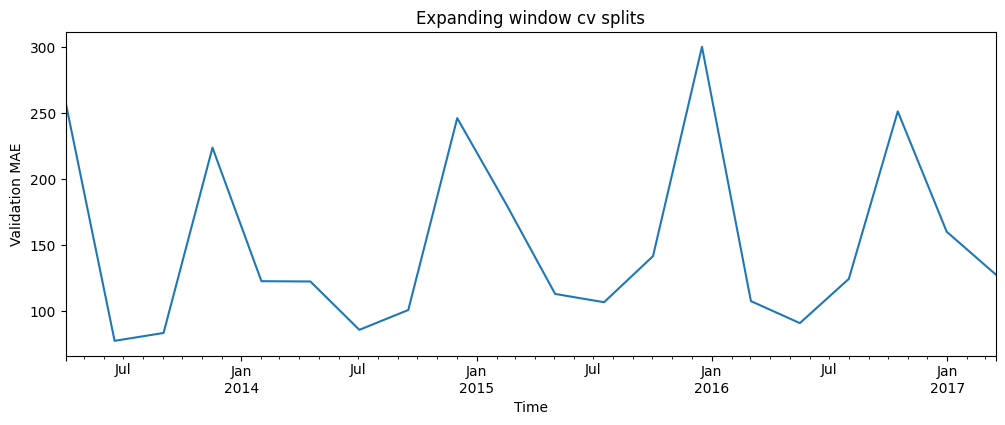

In [19]:
pd.Series(mae_expanding_lst, index=idx_lst).plot()
plt.ylabel('Validation MAE')
plt.xlabel('Time')
plt.title('Expanding window cv splits');

The performance of the model is not consistent over time, this may explain why the model got better results for test than validation previously. Maybe the test set was simply easier to predict.

Also interesting to note is that the model performs significantly worse on the folds that include the end of the year. Let's plot part of the original time series to understand why:

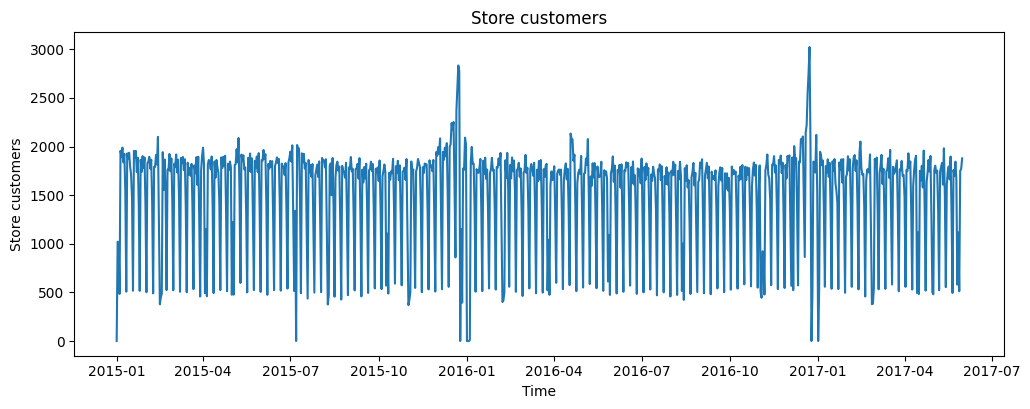

In [20]:
plt.plot(store_train['2015':], label='original data')
plt.ylabel('Store customers')
plt.xlabel('Time')
plt.title('Store customers');

Indeed, it seems that during December the behavior of the time series changes. It's possible that the model may need more features to be able to predict these particular times better. For example, we're only using the day of the week and in some models also the month, but maybe the day of the month could also help. There are always more features to try!

### 2.3 Time series splitter with a sliding window 

Another possible splitter strategy is using a sliding window. This is shown in the plot below where we choose the size of the sliding window to be one year. The train set is the last 365 days before the validation set.

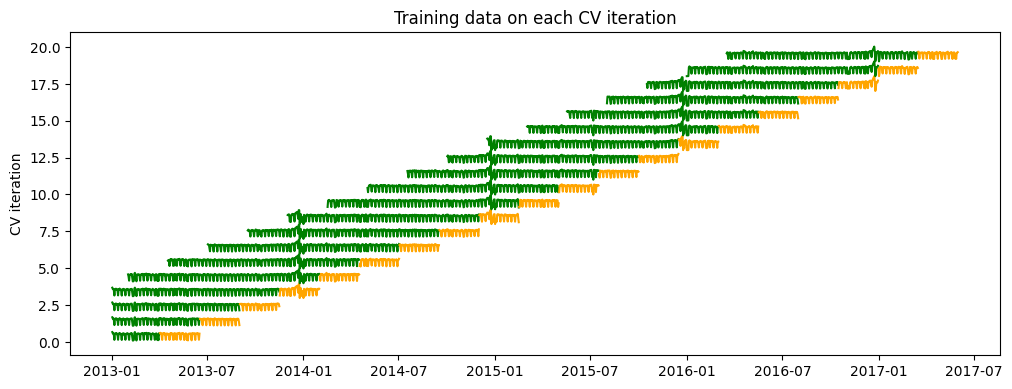

In [21]:
cv = TimeSeriesSplit(n_splits=20, max_train_size=365)

fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(store_train/store_train.max())):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(store_train.index[tr], ii + store_train.iloc[tr]/store_train.max(), color='green')
    ax.plot(store_train.index[tt], ii + store_train.iloc[tt]/store_train.max(), color='orange')

ax.set(title='Training data on each CV iteration', ylabel='CV iteration');

At first it may seem counter-intuitive not to use all available data, but more data doesn't always mean better results. Particularly in the world of time series where many times the processes we're modelling are not stationary. This means that the most recent data may represent the future data better than older data.

In [22]:
n_splits = 20
cv = TimeSeriesSplit(n_splits=n_splits, max_train_size=365)

idx_lst = []
mae_sliding_lst = []

for ii, (tr, tt) in tqdm(enumerate(cv.split(store_train.customers))):
    # Fit the model on training data and collect the coefficients
    train = store_train.iloc[tr].customers
    val = store_train.iloc[tt].customers
    idx_lst.append(store_train.index[tt][0])
    forecast = utils.multistep_forecast(original=train, 
                                     model=GradientBoostingRegressor(random_state=10, n_estimators=20, learning_rate=0.5),
                                     num_lags=2,
                                     num_diffs=0,
                                     weekday=True,
                                     num_periods_ahead=len(val))
    mae_sliding_lst.append(mean_absolute_error(val,forecast))

0it [00:00, ?it/s]

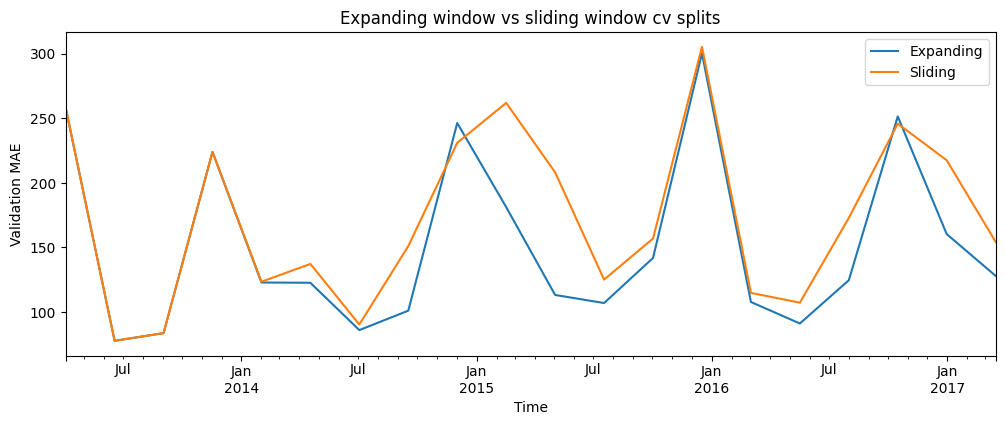

In [23]:
pd.Series(mae_expanding_lst, index=idx_lst).plot(label='Expanding')
pd.Series(mae_sliding_lst, index=idx_lst).plot(label='Sliding')
plt.ylabel('Validation MAE')
plt.xlabel('Time')
plt.title('Expanding window vs sliding window cv splits')
plt.legend();

The results are interesting, they seem to indicate that the end of the year is still the most difficult fold to predict when using the sliding window. But they also show that the sliding window most times obtains worse results than the expanding window. It seems that for this model, there is no advantage in reducing the amount of training data.

## 3. Measuring Uncertainty

From the previous examples we can understand that there is always some uncertainty in our forecasts. In the real world, we are rarely only interested in obtaining the forecast value, we also want to measure the uncertainty that comes with it. For example, the models from the ARIMA family already calculated confidence intervals. How can we get this when using regression models?

A simple way is to train the models for quantile loss. Usually, we optimize regression models to converge to the mean of the independent variable by minimizing the squared error, but we can also use quantile losses to make the model converge to the given quantile. You may recall from the bootcamp that quantiles divide data in parts, e.g. the first quartile comprises the first 25% of the data.

In the example below we use quantiles 0.05 and 0.95. Intuitively, the first one means that the model will converge to values smaller than 5% of the independent variable while the second means that the model will converge to values higher than 95% of the independent variable.

In [24]:
forecast_mean = utils.multistep_forecast(original=store_train.customers, 
                                     model=GradientBoostingRegressor(random_state=10, n_estimators=50, learning_rate=0.2),
                                     num_lags=2,
                                     num_diffs=0,
                                     weekday=True,
                                     month=True,
                                     rolling=['mean','min','max','std'],
                                     holidays=True,
                                     num_periods_ahead=len(store_test))

In [25]:
forecast_95 = utils.multistep_forecast(original=store_train.customers, 
                                     model=GradientBoostingRegressor(random_state=10, n_estimators=50, learning_rate=0.2,
                                                                    loss='quantile',alpha=0.95,),
                                     num_lags=2,
                                     num_diffs=0,
                                     weekday=True,
                                     month=True,
                                     rolling=['mean','min','max','std'],
                                     holidays=True,
                                     num_periods_ahead=len(store_test))

In [26]:
forecast_5 = utils.multistep_forecast(original=store_train.customers, 
                                     model=GradientBoostingRegressor(random_state=10, n_estimators=50, learning_rate=0.2,
                                                                    loss='quantile',alpha=0.05,),
                                     num_lags=2,
                                     num_diffs=0,
                                     weekday=True,
                                     month=True,
                                     rolling=['mean','min','max','std'],
                                     holidays=True,
                                     num_periods_ahead=len(store_test))

In [27]:
f_mean = pd.Series(forecast_mean, index=store_test.index)
f_q05 = pd.Series(forecast_5, index=store_test.index)
f_q95 = pd.Series(forecast_95, index=store_test.index)

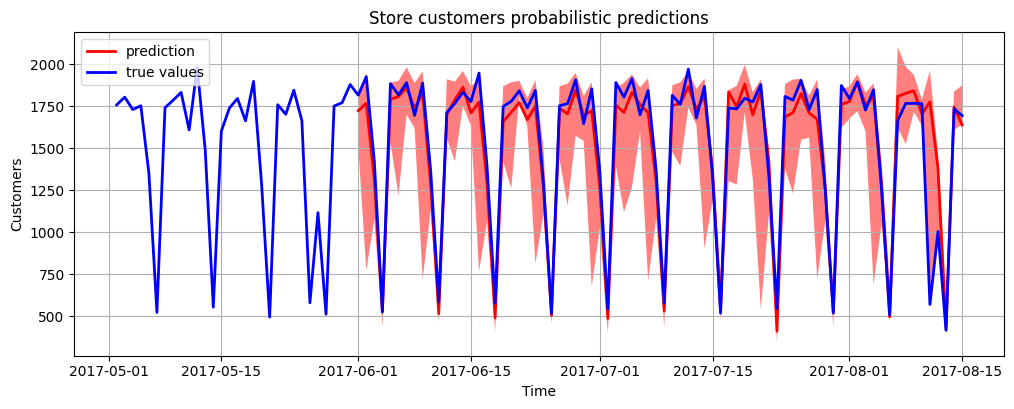

In [28]:
# plot it!
fig, ax = plt.subplots(1)
ax.plot(f_mean.index, f_mean.values, lw=2, label='prediction', color='red')
ax.plot(store[1570:].index, store[1570:].to_numpy(), lw=2, label='true values', color='blue')
ax.fill_between(f_mean.index, f_q95, f_q05, facecolor='red', alpha=0.5)
ax.grid()
plt.xlabel('Time')
plt.ylabel('Customers')
plt.title('Store customers probabilistic predictions')
plt.legend();

## 4. Further reading
For a nice read on the importance of cross validation for time series applications see [this article]( https://blog.daredata.engineering/on-fmcg-and-retail-forecasting/) from the former LDSSA instructor Ivo Bernado.

For a different formulation of time series regression that uses only exogenous and datatime features, see this sklearn [example](https://scikit-learn.org/1.5/auto_examples/applications/plot_cyclical_feature_engineering.html#) and [chapter 7](https://otexts.com/fpp3/regression.html) of Hyndman & Athanasopoulos.